# **Bank Marketing**

In [ ]:
# import libraries

from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import requests

import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_palette('crest')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder


## **Load data**

In [ ]:
import requests, zipfile, io
r = requests.get('http://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip')
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("dataset")

In [ ]:
# y - has the client subscribed a term deposit?
df_bank = pd.read_csv('/content/dataset/bank-full.csv',sep=';')
df_bank


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


### **EDA**

In [ ]:
# check null values
df_bank.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [ ]:
# Count values in each target
df_bank.y.value_counts()

no     39922
yes     5289
Name: y, dtype: int64

In [ ]:
df_bank.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


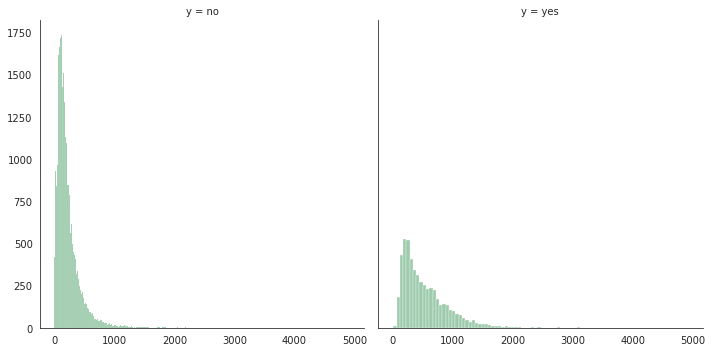

In [ ]:
sns.FacetGrid(df_bank, col='y', height=5).map_dataframe(sns.histplot, x="duration");

**What's the level of the most people who not deposit?**

Most of people who's not deposit is "tertiary".

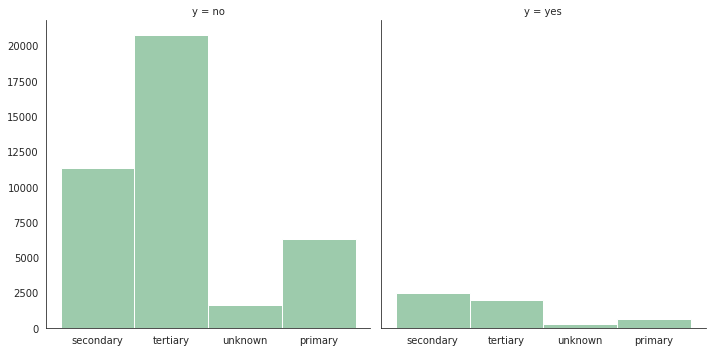

In [ ]:
sns.FacetGrid(df_bank, col='y', height=5).map_dataframe( sns.histplot, x="education");

**What's the average age of people who subscribe in deposit?**

The age of people who subscribe in deposit is between 25 and 60.

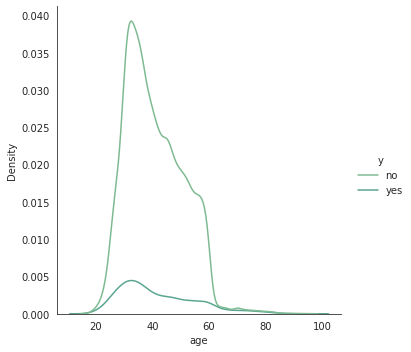

In [ ]:
sns.displot(data = df_bank, x= 'age',hue='y',kind='kde');

**In which month reaches the highest count of subscriptions?**

Most of the subscriptions done in May.

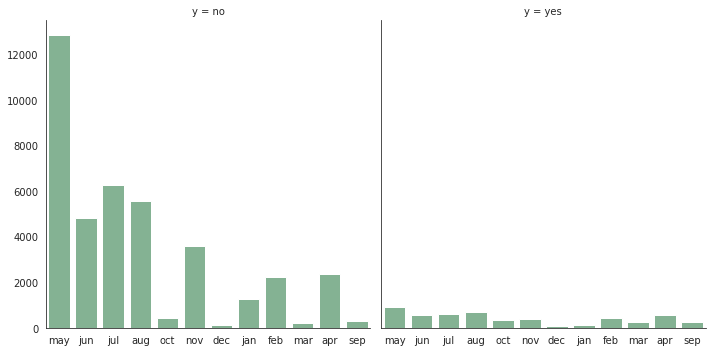

In [ ]:
sns.FacetGrid(df_bank, col='y', height=5).map_dataframe( sns.countplot, x="month");

**Are the people who not deposit have loan or not?**

Most of the people who not deposit desn't have loan.

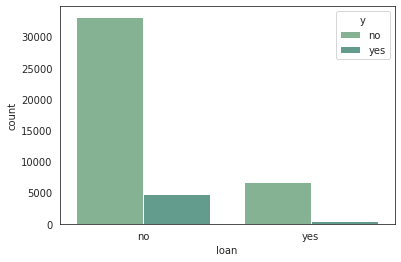

In [ ]:
sns.countplot(data = df_bank, x= 'loan',hue='y');

### **Preproccessing**

**One Hot Encoder**

In [ ]:
# create one hot encoder for 'job'
one_hot = OneHotEncoder(handle_unknown='ignore') 
one_hot_df = one_hot.fit_transform(df_bank[['job']]).toarray() # fit on train data

column_names = [] # to store new column names

# itrate through column names
for y in range(len(one_hot.categories_)):
    for z in range(len(one_hot.categories_[y])):
        # add name of orgin column with new column name
        column_names.append("Job_"+one_hot.categories_[y][z])


# marge new columns with data
oh_df = pd.DataFrame(
    one_hot_df,
    index=df_bank.index,
    columns = column_names
)

df = df_bank.merge(
    oh_df, # Dataframe to merge with train
    on=df_bank.index # column to use to merge on
).set_index("key_0")



**Ordinal Encoder**

In [ ]:
# convet columns to ordinal 
column_names_ordinal = ['default','housing','loan','marital','education','contact','poutcome']
ordinal = OrdinalEncoder()
ordinal_values = ordinal.fit_transform(df[column_names_ordinal])
df[column_names_ordinal] = ordinal_values
df.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,Job_admin.,Job_blue-collar,Job_entrepreneur,Job_housemaid,Job_management,Job_retired,Job_self-employed,Job_services,Job_student,Job_technician,Job_unemployed,Job_unknown
key_0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,58,management,1.0,2.0,0.0,2143,1.0,0.0,2.0,5,may,261,1,-1,0,3.0,no,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,44,technician,2.0,1.0,0.0,29,1.0,0.0,2.0,5,may,151,1,-1,0,3.0,no,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,33,entrepreneur,1.0,1.0,0.0,2,1.0,1.0,2.0,5,may,76,1,-1,0,3.0,no,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### **Split data**

In [ ]:
# split data
X = df.drop(['job','month','y'], axis=1)
y= df['y']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


## **Baseline**

In [ ]:
df_bank.y.value_counts(normalize=True)

no     0.883015
yes    0.116985
Name: y, dtype: float64

## **Build a Model** 

In [ ]:
# create Random Forest Classifier model
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
print("The results for train: ",rfc.score(X_train, y_train))

The results for train:  0.9999669868937968


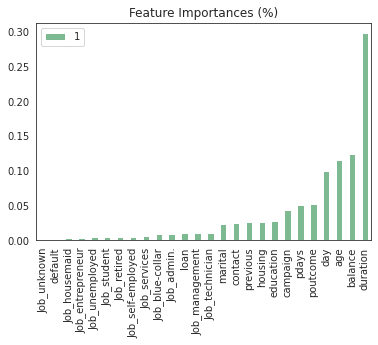

In [ ]:
pd.DataFrame(dict(zip(X_train.columns, rfc.feature_importances_)), index = [1]).T.sort_values(1, ascending=True).plot(kind="bar", title="Feature Importances (%)");

In [ ]:
print("The results for test: ",rfc.score(X_test, y_test))

The results for test:  0.8999329758713137


In [ ]:
print("Result for train")
print(classification_report(y_train, rfc.predict(X_train)))

Result for train
              precision    recall  f1-score   support

          no       1.00      1.00      1.00     26747
         yes       1.00      1.00      1.00      3544

    accuracy                           1.00     30291
   macro avg       1.00      1.00      1.00     30291
weighted avg       1.00      1.00      1.00     30291



In [ ]:
print("Result for test")
print(classification_report(y_test, rfc.predict(X_test)))

Result for test
              precision    recall  f1-score   support

          no       0.92      0.97      0.94     13175
         yes       0.62      0.37      0.46      1745

    accuracy                           0.90     14920
   macro avg       0.77      0.67      0.70     14920
weighted avg       0.89      0.90      0.89     14920



In [ ]:
print("Baseline: ",df_bank.y.value_counts(normalize=True)[0])

Baseline:  0.8830151954170445


## **Improve model**

In [ ]:
param_grid = {
    "n_estimators": [20,40,60], 
    "criterion": ["gini", "entropy"], 
    "max_depth": [2,4,6,8,10] 
    
}

grid = GridSearchCV(
    rfc, # model
    param_grid, # hyperparameter to tune
    cv = 5, # K-fold cross validation
    n_jobs=-1, # use all cores on cpu
    verbose=1 # show output
)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.2min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [ ]:
print("The result of train using GridSearchCV :",grid.score(X_train, y_train))
print("The result of test using GridSearchCV :",grid.score(X_test, y_test))

The result of train using GridSearchCV : 0.92327754118385
The result of test using GridSearchCV : 0.9016085790884718
